### TODO 
- [ ]figure out how to read in PDF 


# working pdf 

In [1]:
#  # only imports first page 
# def pdf_table_to_dataframe(file_path, page_number):
#     with pdfplumber.open(file_path) as pdf:
#         page = pdf.pages[page_number]
#         table = page.extract_table()

#     # Convert the table (a list of lists) into a DataFrame
#     df = pd.DataFrame(table[1:], columns=table[0])  # Use the first row as headers
#     return df

# # Example usage, specify the page number with the table
# df_table = pdf_table_to_dataframe("data/Sworn_personnel_since_2012.pdf", page_number=10)
# print(df_table)

# starting here 

In [2]:
import pandas as pd
import pdfplumber
import os
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns


In [3]:
salary = pd.read_csv('data/SalaryData.csv')
citations_2023 = pd.read_csv('data/citations2023.csv')
officer_number = pd.read_csv('data/sworn_officers.csv')

In [4]:
# Split the single column into the correct 3 and deletes the old column
officer_number[['badge', 'fname', 'lname']] = officer_number['badge fname lname'].str.split(n=2, expand=True)
officer_number.drop(columns=['badge fname lname'], inplace=True, errors='ignore')

# Define expected columns for validation then validates
expected_cols = ['badge',	'fname', 'lname']
if list(officer_number.columns) != expected_cols:
    print("Columns don't match; expected columns for this project are:", expected_cols)
else:
    print("Columns match the expected structure.")

# Rename columns in officer_number for merging
officer_number.rename(columns={'fname': 'First_Name', 'lname': 'Last_Name'}, inplace=True)

Columns match the expected structure.


## salary

In [5]:
# calculates total weekly hrs worked 
salary['Hr_Rate'] = salary['Regular_Rate'] / 2080
salary['Ot_Rate'] = salary['Hr_Rate'] * 1.5
salary['Hr_Worked'] = salary['Overtime_Rate'] / salary['Ot_Rate'] / 52 + 40
salary.replace([np.inf, -np.inf], 40, inplace=True)
salary = salary[salary['CalYear']==2023]

# splits name to first middle and last 
salary[['Last_Name', 'First_Middle_Names']] = salary['Employee_Name'].str.split(', ', expand=True)
salary[['First_Name', 'Middle_Name']] = salary['First_Middle_Names'].str.split(' ', n=1, expand=True)
salary['Middle_Name'] = salary['Middle_Name'].fillna('')
salary = salary.drop(columns=['First_Middle_Names'])

# limits the data to LMPD
departments_of_interest = [
    'Louisville Metro Police',
    'Louisville Metro Police Department',
    # 'Metro Corrections',
    # 'Department of Corrections'
]
salary = salary[salary['Department'].isin(departments_of_interest)] 

# Strip whitespace to make all the joins work 
salary['First_Name'] = salary['First_Name'].astype(str).str.strip().str.lower()
salary['Last_Name'] = salary['Last_Name'].astype(str).str.strip().str.lower()

officer_number['First_Name'] = officer_number['First_Name'].astype(str).str.strip().str.lower()
officer_number['Last_Name'] = officer_number['Last_Name'].astype(str).str.strip().str.lower()

# Perform the merge
salary = salary.merge(officer_number[['First_Name', 'Last_Name', 'badge']],
                      on=['First_Name', 'Last_Name'], 
                      how='left')

# Rename 'badge' column to 'badge_number'
salary.rename(columns={'badge': 'badge_number'}, inplace=True)

# sorting by hours worked
salary = salary.sort_values(by='Hr_Worked', ascending=False)

salary.head()


,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,ObjectId,Hr_Rate,Ot_Rate,Hr_Worked,Last_Name,First_Name,Middle_Name,badge_number
373,2023,"Williams, Derrick D",Louisville Metro Police Department,Police Officer,80745.6,72354.57,96567.53,10524.01,NaN,180551.11,1602,34.785851,52.178776,75.590484,williams,derrick,D,7648
448,2023,"Jenkins, Todd Barry",Louisville Metro Police Department,Police Sergeant,99382.4,94284.36,121917.23,9954.58,NaN,226221.17,1807,45.329019,67.993529,74.482136,jenkins,todd,Barry,7785
452,2023,"Starcher, Candice Lynn",Louisville Metro Police Department,Information Process Tech II,44865.6,44865.60,57306.23,1563.12,NaN,103734.95,1814,21.570000,32.355000,74.060976,starcher,candice,Lynn,NaN
1019,2023,"Dahlgren, Patrick Barthold",Louisville Metro Police Department,Police Officer,72779.2,66606.83,80677.22,9312.11,NaN,158741.16,3719,32.022514,48.033772,72.299879,dahlgren,patrick,Barthold,5141
48,2023,"Ernst, Eric Michael",Louisville Metro Police Department,Police Officer,86673.6,77892.77,94304.66,9266.18,NaN,184267.29,245,37.448447,56.172671,72.285293,ernst,eric,Michael,2969


## Final DF 

| col name | notes |
| --- | --- |
| Officer name | text |
| badge number | text |
| hours worked | text |
| tickets | text |
| most common citations? | text |
| % of race ticketed | text |

from salary 
- First_Name 
- Last_Name 
- Hr_Worked
- YTD_Total
- badge_number

from citation 
- number_of_tickets
- most common citation 
- % of race ticketed 

## citation to do 

- [ ] Clean citations_2023
- [ ] value count number of tickets to officer name 
- [ ] define parameters for citations 
- [ ] calculate race percent ticketed by officer

In [6]:

# citations_2023.columns

citation_cols_to_drop = ['AGENCY_DESC', 'CASE_NUMBER', 'CITATION_YEAR',
       'CITATION_CONTROL_NUMBER', 'CITATION_TYPE_DESC', 'CITATION_DATE',
       'CITATION_LOCATION', 'DIVISION', 'BEAT', 'PERSONS_HOME_CITY',
       'PERSONS_ETHNICITY', 'PERSONS_AGE', 'ASCF_CODE',
       'PERSONS_HOME_STATE', 'PERSONS_HOME_ZIP', 'UCR_CODE', 'UCR_DESC', 'VIOLATION_CODE', 'STATUTE', 'ObjectId']


race_mapping = {
          'W': 'WHITE',
          'B': 'BLACK',
          'H': 'HISPANIC',
          'A': 'ASIAN',
          'U': 'UNKNOWN'
      }
citations_2023['PERSONS_RACE'] = citations_2023['PERSONS_RACE'].str.strip().map(race_mapping)

citations_2023 = citations_2023.drop(citation_cols_to_drop, axis=1, errors='ignore') 
citations_2023.head()

,BADGE_ID,PERSONS_SEX,PERSONS_RACE,CHARGE_DESC
0,2017,F,WHITE,FAIL OF NON-OWNER/OPER TO MAINTAIN REQ INS/SEC...
1,2017,F,BLACK,SPEEDING 10 MPH OVER LIMIT ...
2,2017,M,WHITE,NO OPERATORS/MOPED LICENSE ...
3,2089,M,WHITE,FAILURE OF OWNER TO MAINTAIN REQUIRED INS/SECU...
4,2098,F,WHITE,NO OR EXPIRED REGISTRATION PLATES ...


'HISPANIC',
          'A': 'ASIAN',
          'U': 'UNKNOWN'

In [7]:
# Grouping by BADGE_ID and aggregating
cleaned_citation_23 = citations_2023.groupby('BADGE_ID').agg(
    number_of_tickets = ('BADGE_ID', 'size'),
    Female_Drivers = ('PERSONS_SEX', lambda x: (x == 'F').sum()),
    Male_Drivers = ('PERSONS_SEX', lambda x: (x == 'M').sum()),
    White_Drivers = ('PERSONS_RACE', lambda x: (x == 'WHITE').sum()),
    Black_Drivers = ('PERSONS_RACE', lambda x: (x == 'BLACK').sum()),
    Asian_Drivers = ('PERSONS_RACE', lambda x: (x == 'ASAIN').sum()),
    Unknown_Drivers = ('PERSONS_RACE', lambda x: (x == 'UNKNOWN').sum()),
).reset_index()

# Calculate percentages
cleaned_citation_23['Female_Percentage'] = (cleaned_citation_23['Female_Drivers'] / cleaned_citation_23['number_of_tickets'] * 100).astype(float)
cleaned_citation_23['Male_Percentage'] = (cleaned_citation_23['Male_Drivers'] / cleaned_citation_23['number_of_tickets'] * 100).astype(float)

cleaned_citation_23 = cleaned_citation_23.sort_values(by='number_of_tickets', ascending=False)

# Output the result
cleaned_citation_23

,BADGE_ID,number_of_tickets,Female_Drivers,Male_Drivers,White_Drivers,Black_Drivers,Asian_Drivers,Unknown_Drivers,Female_Percentage,Male_Percentage
512,7578,905,340,565,612,280,0,4,37.569061,62.430939
19,2395,701,273,428,504,190,0,0,38.944365,61.055635
517,7628,629,205,424,194,422,0,0,32.591415,67.408585
420,7321,498,118,380,285,204,0,0,23.694779,76.305221
338,6886,491,194,297,337,153,0,0,39.511202,60.488798
...,...,...,...,...,...,...,...,...,...,...
556,7815,1,0,1,1,0,0,0,0.000000,100.000000
367,7118,1,0,1,1,0,0,0,0.000000,100.000000
368,7120,1,0,1,0,1,0,0,0.000000,100.000000
562,7844,1,0,1,0,0,0,0,0.000000,100.000000


In [8]:
print("Columns in cleaned_citation_23:", cleaned_citation_23.columns)


Columns in cleaned_citation_23: Index(['BADGE_ID', 'number_of_tickets', 'Female_Drivers', 'Male_Drivers',
       'White_Drivers', 'Black_Drivers', 'Asian_Drivers', 'Unknown_Drivers',
       'Female_Percentage', 'Male_Percentage'],
      dtype='object')


In [9]:
# Convert both columns to string type
salary['badge_number'] = salary['badge_number'].astype(str)
cleaned_citation_23['BADGE_ID'] = cleaned_citation_23['BADGE_ID'].astype(str)

# Now perform the merge
cleaned_final = salary.merge(cleaned_citation_23, left_on='badge_number', right_on='BADGE_ID', how='left')


In [10]:
cleaned_final.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,...,BADGE_ID,number_of_tickets,Female_Drivers,Male_Drivers,White_Drivers,Black_Drivers,Asian_Drivers,Unknown_Drivers,Female_Percentage,Male_Percentage
0,2023,"Williams, Derrick D",Louisville Metro Police Department,Police Officer,80745.6,72354.57,96567.53,10524.01,NaN,180551.11,...,7648,4.0,0.0,4.0,1.0,3.0,0.0,0.0,0.000000,100.000000
1,2023,"Jenkins, Todd Barry",Louisville Metro Police Department,Police Sergeant,99382.4,94284.36,121917.23,9954.58,NaN,226221.17,...,7785,19.0,9.0,10.0,12.0,5.0,0.0,2.0,47.368421,52.631579
2,2023,"Starcher, Candice Lynn",Louisville Metro Police Department,Information Process Tech II,44865.6,44865.60,57306.23,1563.12,NaN,103734.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,"Dahlgren, Patrick Barthold",Louisville Metro Police Department,Police Officer,72779.2,66606.83,80677.22,9312.11,NaN,158741.16,...,5141,40.0,9.0,31.0,27.0,13.0,0.0,0.0,22.500000,77.500000
4,2023,"Ernst, Eric Michael",Louisville Metro Police Department,Police Officer,86673.6,77892.77,94304.66,9266.18,NaN,184267.29,...,2969,63.0,31.0,32.0,49.0,13.0,0.0,0.0,49.206349,50.793651


In [11]:
print(f'columns in cleaned_final: \n {cleaned_final.columns}')

columns in cleaned_final: 
 Index(['CalYear', 'Employee_Name', 'Department', 'jobTitle', 'Annual_Rate',
       'Regular_Rate', 'Overtime_Rate', 'Incentive_Allowance', 'Other',
       'YTD_Total', 'ObjectId', 'Hr_Rate', 'Ot_Rate', 'Hr_Worked', 'Last_Name',
       'First_Name', 'Middle_Name', 'badge_number', 'BADGE_ID',
       'number_of_tickets', 'Female_Drivers', 'Male_Drivers', 'White_Drivers',
       'Black_Drivers', 'Asian_Drivers', 'Unknown_Drivers',
       'Female_Percentage', 'Male_Percentage'],
      dtype='object')


# Hours to tickets

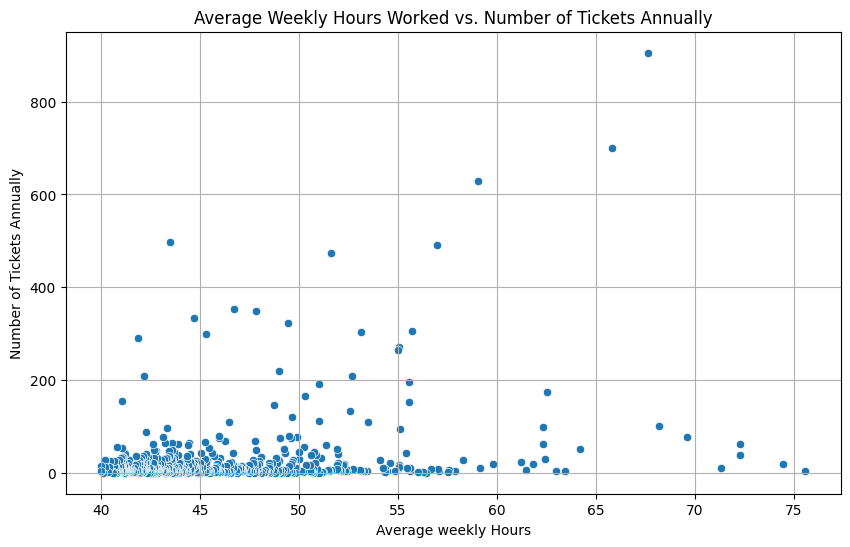

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets')
plt.title('Average Weekly Hours Worked vs. Number of Tickets Annually')
plt.xlabel('Average weekly Hours')
plt.ylabel('Number of Tickets Annually')
plt.grid()
plt.show()


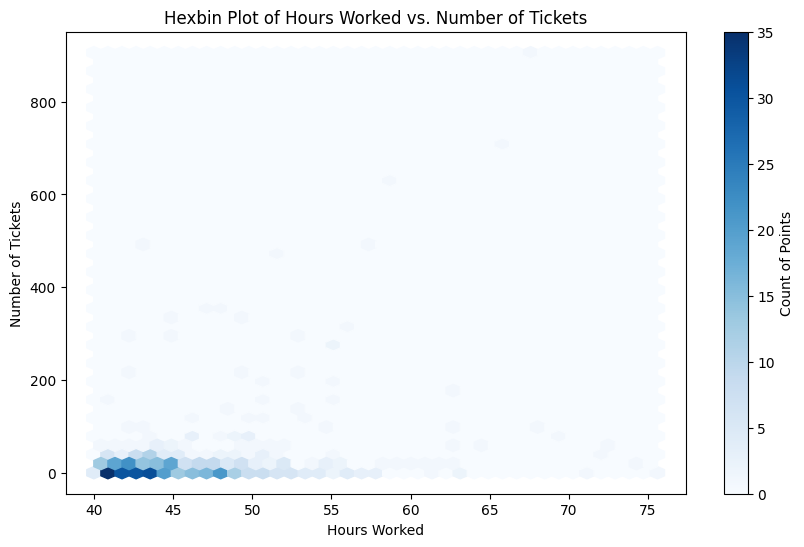

In [13]:
plt.figure(figsize=(10, 6))
plt.hexbin(cleaned_final['Hr_Worked'], cleaned_final['number_of_tickets'], gridsize=40, cmap='Blues')
plt.colorbar(label='Count of Points')
plt.title('Hexbin Plot of Hours Worked vs. Number of Tickets')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.grid(False)
plt.show()


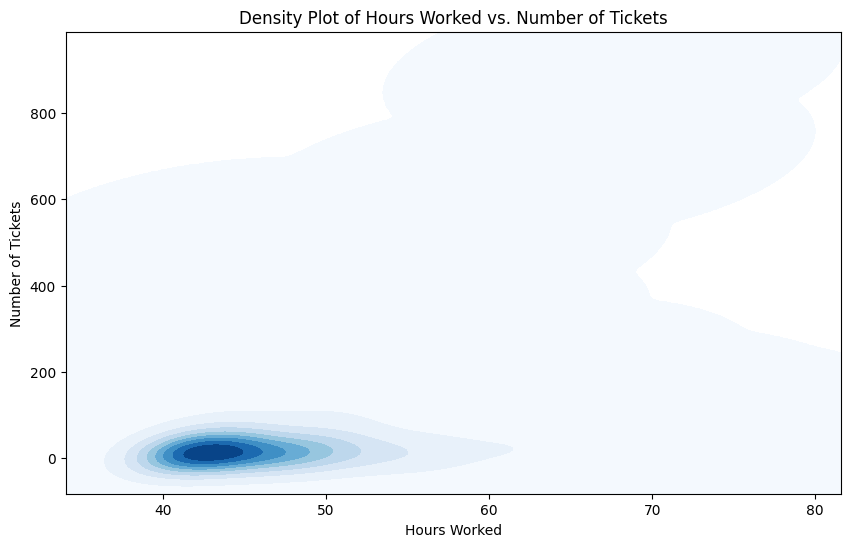

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets', fill=True, cmap='Blues', thresh=0)
plt.title('Density Plot of Hours Worked vs. Number of Tickets')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.show()


# hours to pay

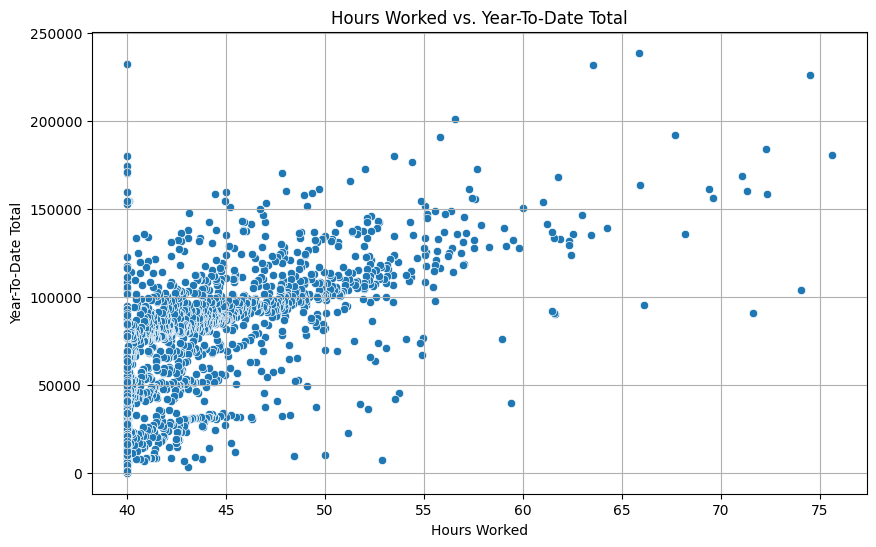

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_final, x='Hr_Worked', y='YTD_Total')
plt.title('Hours Worked vs. Year-To-Date Total')
plt.xlabel('Hours Worked')
plt.ylabel('Year-To-Date Total')
plt.grid()
plt.show()


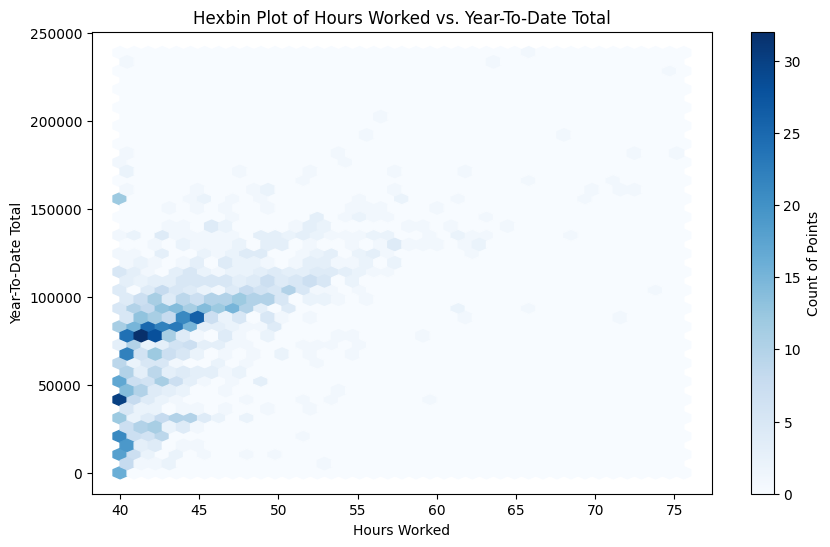

In [16]:
plt.figure(figsize=(10, 6))
plt.hexbin(cleaned_final['Hr_Worked'], cleaned_final['YTD_Total'], gridsize=40, cmap='Blues')
plt.colorbar(label='Count of Points')
plt.title('Hexbin Plot of Hours Worked vs. Year-To-Date Total')
plt.xlabel('Hours Worked')
plt.ylabel('Year-To-Date Total')
plt.grid(False)
plt.show()


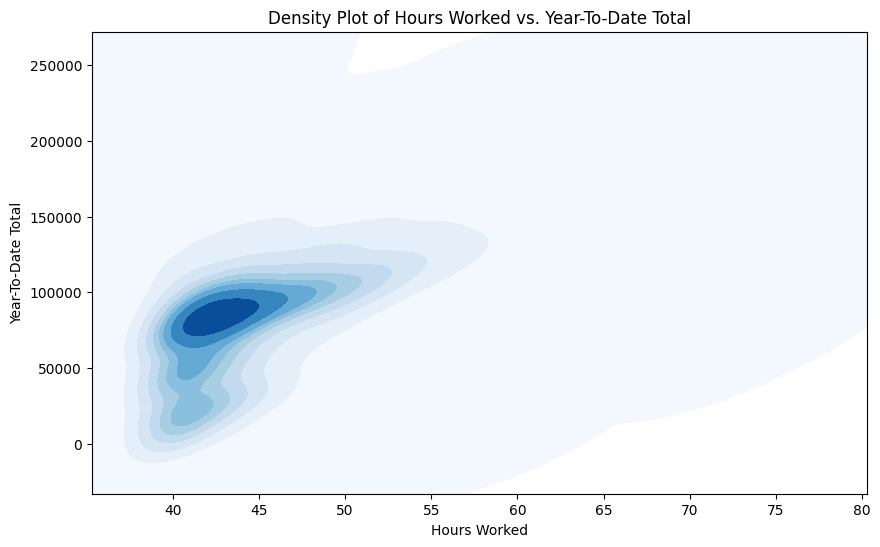

In [17]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cleaned_final, x='Hr_Worked', y='YTD_Total', fill=True, cmap='Blues', thresh=0)
plt.title('Density Plot of Hours Worked vs. Year-To-Date Total')
plt.xlabel('Hours Worked')
plt.ylabel('Year-To-Date Total')
plt.show()



The weak correlation coefficients of 0.29 (Pearson) and 0.14 (Spearman) suggest that there is only a slight positive relationship between hours worked and the number of tickets handled, indicating that increased hours do not consistently lead to more tickets. However, correlation does not imply causation, and these results do not definitively prove that working more hours does not result in handling more tickets.

In [18]:
correlation = cleaned_final['Hr_Worked'].corr(cleaned_final['number_of_tickets'])
print(f'Correlation between Hours Worked and Number of Tickets: {correlation:.2f}')


Correlation between Hours Worked and Number of Tickets: 0.29


In [19]:
spearman_correlation = cleaned_final['Hr_Worked'].corr(cleaned_final['number_of_tickets'], method='spearman')
print(f'Spearman Correlation: {spearman_correlation:.2f}')

Spearman Correlation: 0.14


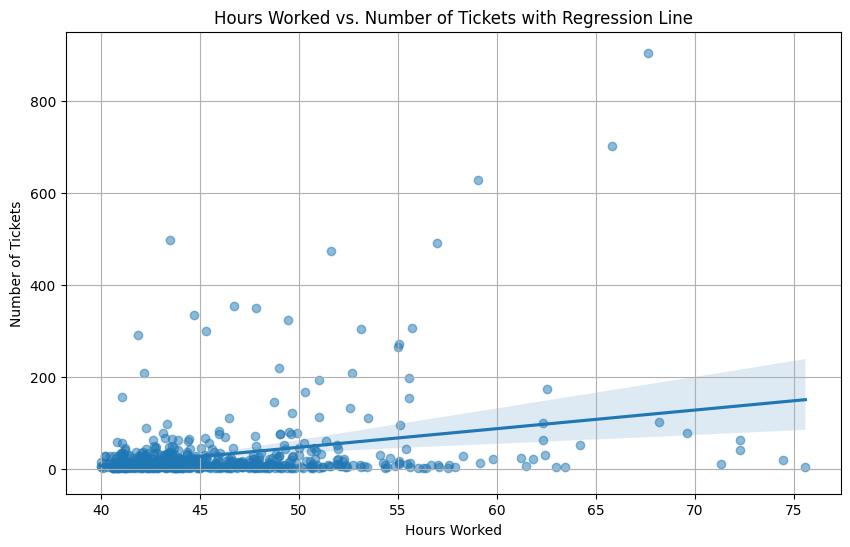

In [20]:
plt.figure(figsize=(10, 6))
sns.regplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets', scatter_kws={'alpha': 0.5})
plt.title('Hours Worked vs. Number of Tickets with Regression Line')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.grid()
plt.show()


In [21]:
# Calculate Salary Spend Per Ticket
cleaned_final['Salary_Spend_Per_Ticket'] = cleaned_final['YTD_Total'] / cleaned_final['number_of_tickets']

# Handle potential /0 by replacing inf values with NaN
cleaned_final['Salary_Spend_Per_Ticket'] = cleaned_final['Salary_Spend_Per_Ticket'].replace([float('inf'), -float('inf')], np.nan)


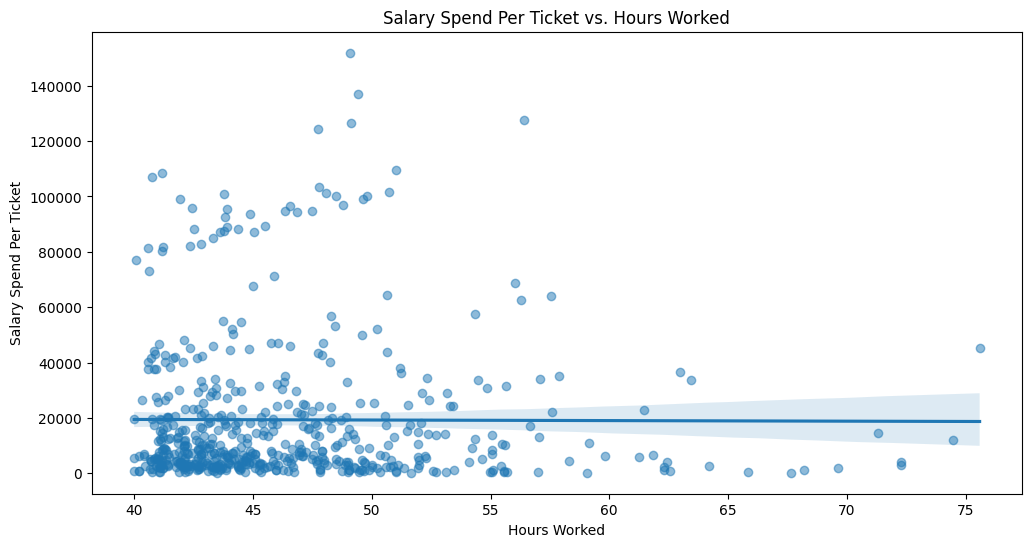

In [33]:
# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.regplot(x='Hr_Worked', y='Salary_Spend_Per_Ticket', data=cleaned_final, scatter_kws={'alpha':0.5})
plt.title('Salary Spend Per Ticket vs. Hours Worked')
plt.xlabel('Hours Worked')
plt.ylabel('Salary Spend Per Ticket')
plt.show()


# previous project to steal functions from. 

In [22]:
def OT(year):
    df_filtered = df[df['CalYear'] == year]
    df_filtered = df_filtered[df_filtered['Overtime_Rate'] > df_filtered['Regular_Rate']]
    # df_filtered = df_filtered.sort_values(by='YTD_Total', ascending=False)
    return df_filtered

def Dep_yearly(year):
    pd.options.display.float_format = '{:.2f}'.format
    department = df[df['CalYear'] == year]
    department = department.groupby(['CalYear', 'Department'])['YTD_Total'].sum().reset_index()
    department = department.sort_values(by='YTD_Total', ascending=False)
    department.head()
    return department

def process_salary_data(url):
    df = pd.read_csv(url)
    df['Hr_Rate'] = df['Regular_Rate'] / 2080
    df['Ot_Rate'] = df['Hr_Rate'] * 1.5
    df['Hr_Worked'] = df['Overtime_Rate'] / df['Ot_Rate'] / 52 + 40
    df = df.sort_values(by='Hr_Worked', ascending=False)
    return df

data_url = "data/SalaryData.csv"
df = process_salary_data(data_url)
df

def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

def a_dep(df):
    ax = df.plot.bar(x='Department')
    ax.legend_ = None
    ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    plt.gcf().set_size_inches(10, 6)
    plt.ylabel('Millions USD')
    plt.title('Annual Salary Spend by Department')
    plt.show()

def OT_E(dataframe):
    top_20 = dataframe.head(20)
    top_20.plot.bar(x='Employee_Name', y='Hr_Worked')
    plt.xticks()
    plt.xlabel('Employee Name')
    plt.ylabel('Hours Worked')
    plt.title('Top 15 Employees by Hours Worked')
    plt.show()

def plot_department_counts(dataframe):
    department_counts = dataframe['Department'].value_counts()
    department_counts.plot(kind='bar')
    plt.xlabel('Department')
    plt.ylabel('Count')
    plt.title('Department Counts')
    plt.show()

| Syntax	| Description |
| --- | --- |
| process_salary_data(data_url) |	This function does math to calculate the hourly rate overtime rate and the hours worked by an employee |
| axx |	a followed by the year is the annual department salary spend by department. |
| Dep_yearly(XXXX) |	This is the cleaning function that groups all the employee salaries by department. |
| OT(XXXX) | This filters the overtime to the selected year |
| OT_E(dfXX) | This plots the top 20 employees with the most overtime |
| millions_formatter(x, pos) |	Hidden function that formats the axis of all plots to be in millions format. |


In [23]:
data_url = 'data/SalaryData.csv'

In [24]:
salary = process_salary_data(data_url)

In [25]:
a23 = Dep_yearly(2023)
a23.head()

,CalYear,Department,YTD_Total
21,2023,Louisville Metro Police Department,122305345.81
19,2023,Louisville Fire,42551459.37
7,2023,Department of Corrections,30447514.89
43,2023,Public Works & Assets,26300349.75
41,2023,Parks & Recreation,13592030.46


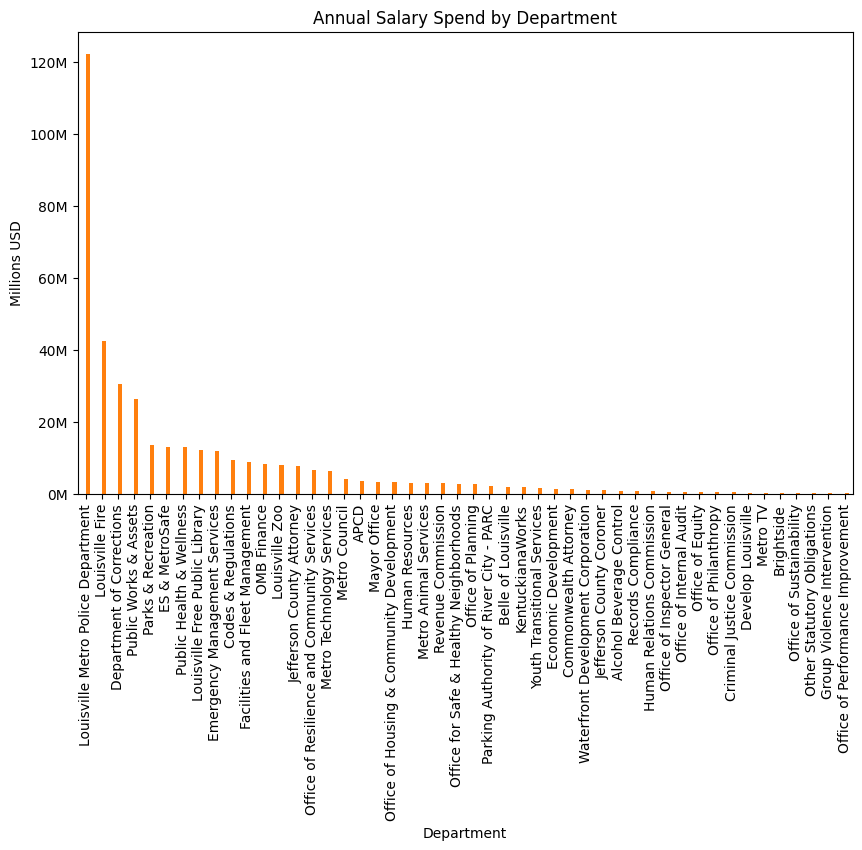

In [26]:
a_dep(a23)

In [27]:
df23 = OT(2023)
df23.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,ObjectId,Hr_Rate,Ot_Rate,Hr_Worked
2539,2023,"Ingram, Lydia Ann",Louisville Metro Police Department,LMPD Service Center Technician,41995.20,0.00,151.43,0.00,NaN,151.43,2540,0.00,0.00,inf
5250,2023,"Watson, Danny W",Parks & Recreation,Golf Operations Supervisor I,44075.20,0.00,84.76,0.00,NaN,1168.86,5251,0.00,0.00,inf
491,2023,"Murphy, Paul P.",Louisville Fire,Fire Apparatus Operator 56hr,67362.05,40383.16,97922.36,39150.60,NaN,177456.12,492,19.41,29.12,104.66
2231,2023,"Herndon, Adam B",Louisville Fire,Fire Company Commander 56hr,76896.77,42926.26,94210.22,29398.80,NaN,167021.04,2232,20.64,30.96,98.53
220,2023,"Hudson, Daryell W",Louisville Fire,Fire Apparatus Operator 56hr,67362.05,25227.89,51028.06,21927.44,NaN,107718.33,221,12.13,18.19,93.94


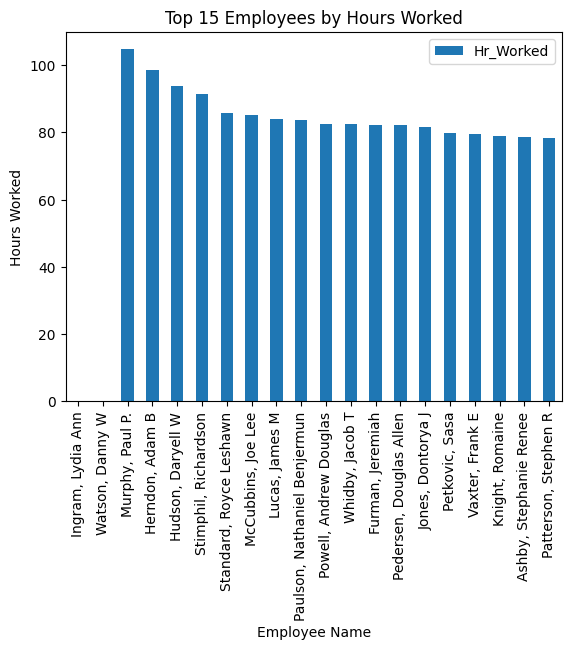

In [28]:
OT_E(df23)